In [1]:
from IPython.display import display
from IPython.display import Image

# A Python tutorial on validating gVirtualXRay:
## Analytic simulation vs. CT data
### Authors: F. P. Vidal

# TODO

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable to images generated with the state-of-the-art Monte Caro simulation packages. We take into account i) a realistic beam spectrum and ii) the energy response of the detector.

**Material and Methods:** We simulate an image with gVirtualXRay and compare it with a ground truth image. For this purpose, we use [Gate],(http://www.opengatecollaboration.org/) a wrapper for CERN's state-of-the-art Monte Caro simulation tool: [Geant4](https://geant4.web.cern.ch/).

In our simulation the source-to-object distance (SOD) is 1000mm, and the source-to-detector distance (SDD) is 1125mm. The beam spectrum is polychromatic. The voltage is 85 kV. The filteration is 0.1 mm of copper and 1 mm of aluminium. The energy response of the detector is considered. It mimics a 600-micron thick CsI scintillator.

In [2]:
# Image(filename="../doc/pediatric-setup.png")

The sample is made of a 70x70x15mm box of water, in which 5 columns of 3 spheres of different radii (2, 3.5, and 5mm) have been inserted. A given material is associated to the spheres of each column (bone (cortical), blood (whole), brain (grey/white matter), breast tissue, and adipose tissue). The columns are ordered in decreasing density. We use the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/). The material composition is available at [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).

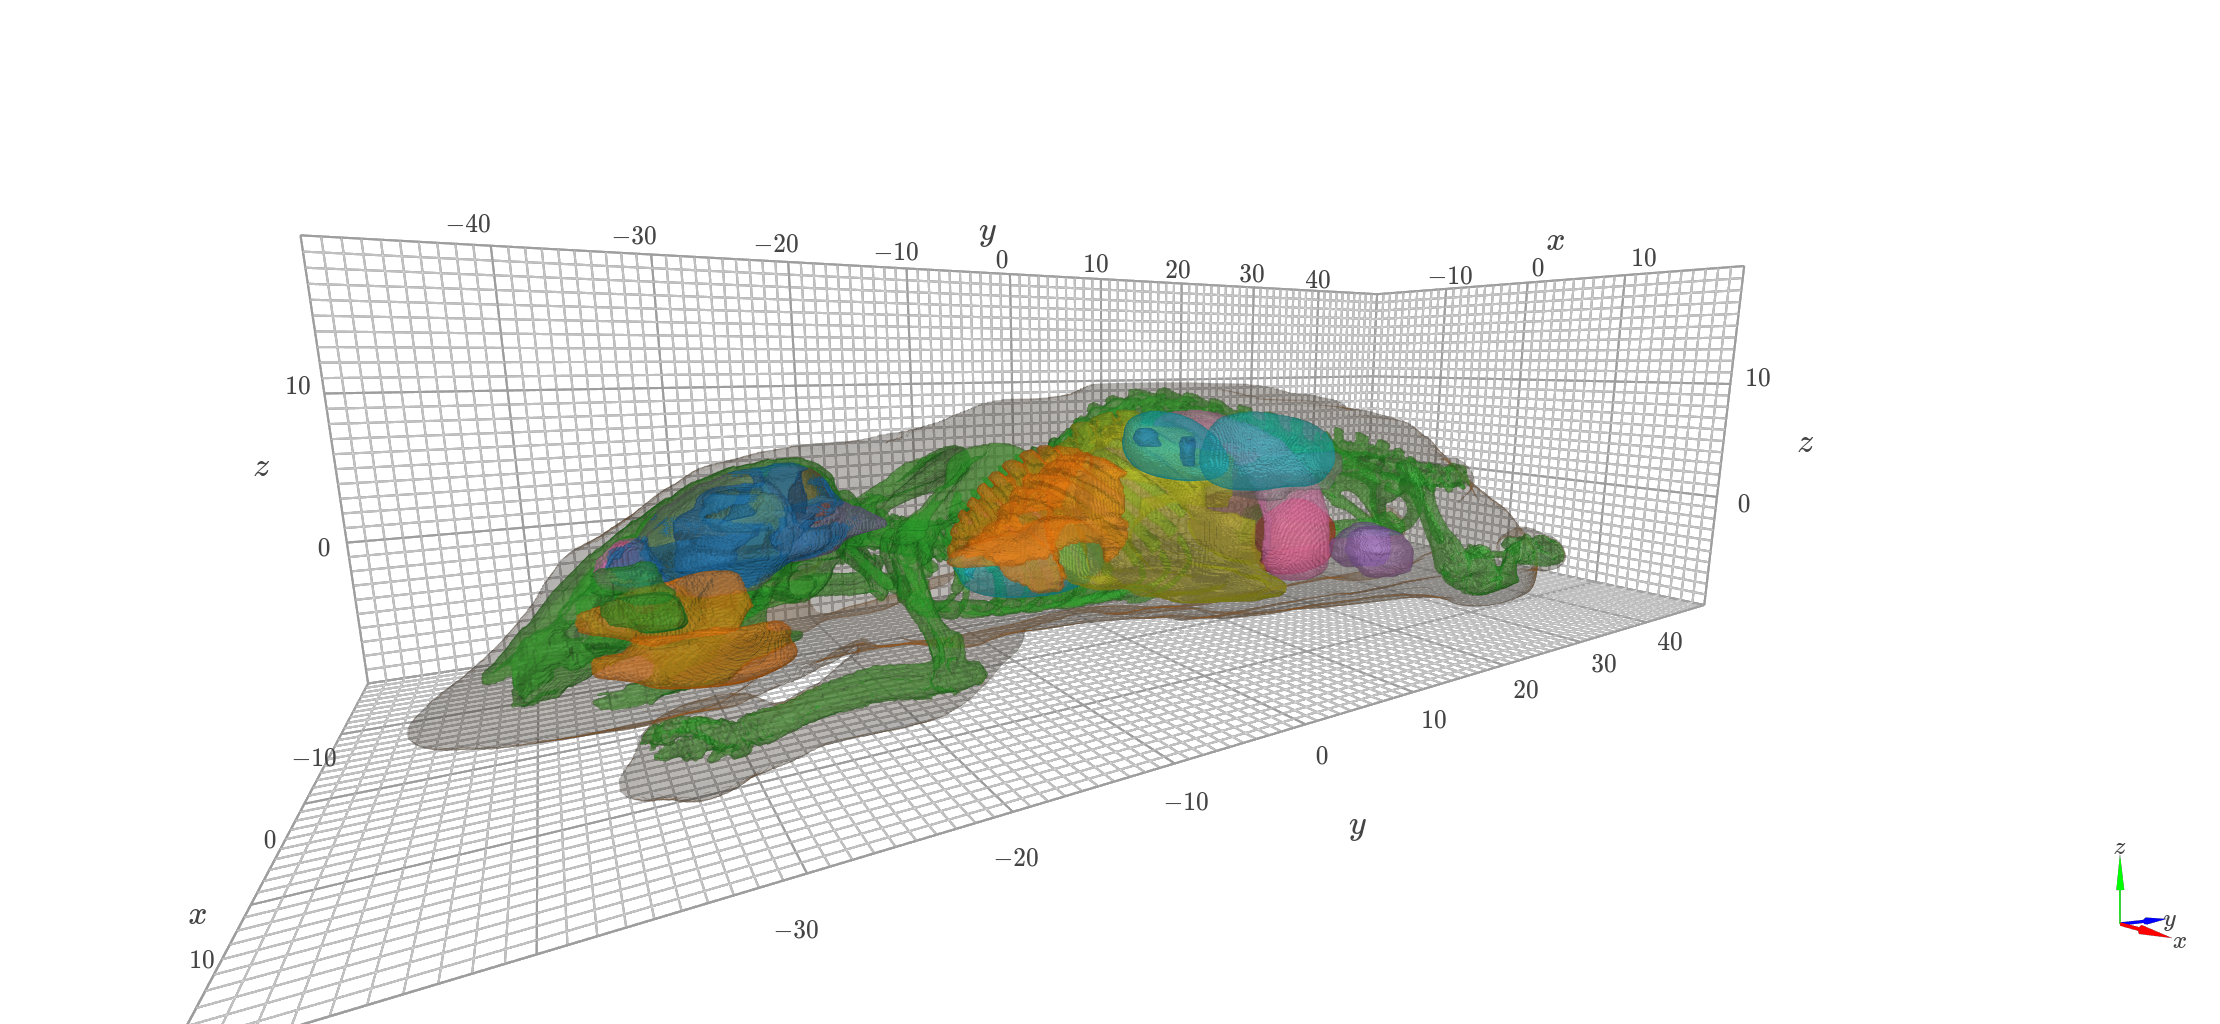

In [3]:
Image(filename="plots/digimouse_model.png", width=800)

**Results:** The [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), between the two simulated images is **MAPE 3.43%**. The **[zero-mean normalised cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) is 99.99%**. 
The **[Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity) is 0.99**. 
As MAPE is relatively low (less than 5%), SSIM is high (close to 1), and ZNCC is high (close to 100%), we can conclude that X-ray images simulated with gVirtualXRay on GPU in milliseconds are comparable to Monte Carlo simulations that ran on supercomputers for days.

## Import packages

In [4]:
%matplotlib inline

import os # Locate files
import urllib # Download file
import zipfile # Unzip the file

import math
import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import matplotlib

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
from matplotlib.colors import PowerNorm # Look up table
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

import tomopy
from skimage.transform import iradon

from scipy.stats import pearsonr # Compute the correlatio coefficient

from skimage.util import compare_images # Checkboard comparison between two images
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_percentage_error as mape
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize # Resample the images

from tifffile import imread, imsave # Load/Write TIFF files
import imageio

import datetime # For the runtime

import k3d, base64
import SimpleITK as sitk
from stl import mesh
import random
from sitk2vtk import sitk2vtk

import gvxrPython3 as gvxr # Simulate X-ray images

import json2gvxr # Set gVirtualXRay and the simulation up
from utils import * # Code shared across more than one notebook

SimpleGVXR 1.0.1 (2021-12-13T16:30:11) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2021-12-13T16:30:10) [Compiler: GNU g++] on Linux


## Define constants for this experiment

In [5]:
number_of_projections = 360 * 2 - 1;
angular_step = 180 / number_of_projections;
theta_deg = np.linspace(0.0, -angular_step * number_of_projections, num=number_of_projections, endpoint=False)

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [6]:
json2gvxr.initGVXR("notebook-digimouse.json", "OPENGL")

Create an OpenGL context: 800x450
gvxrStatus:	Create window 0
gvxrStatus:	Create window 
0 0 500 500
OpenGL renderer:   NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    3.2.0 NVIDIA 470.42.01
OpenGL vender:     NVIDIA Corporation
Use OpenGL 4.5.
0 0 800 450


## X-ray source

We create an X-ray source. It is a point source.

In [7]:
json2gvxr.initSourceGeometry("notebook-digimouse.json")

Set up the beam
	Source position: [0.0, 150.0, 0.0, 'mm']
	Source shape: ParallelBeam


## Spectrum

The spectrum is monochromatic.

## Detector

Create a digital detector

In [8]:
json2gvxr.initDetector("notebook-digimouse.json")

Set up the detector
	Detector position: [0.0, -150.0, 0.0, 'mm']
	Detector up vector: [0, 0, -1]
	Detector number of pixels: [1062, 208]
	Pixel spacing: [0.10002748229472694, 0.1, 'mm']


In [9]:
nb_pixels = gvxr.getDetectorNumberOfPixels()
detector_size = gvxr.getDetectorSize("mm")
pixel_width = detector_size[0] / nb_pixels[0]
pixel_height = detector_size[1] / nb_pixels[1]

## Reference CT volume

We first load the reference CT volume. It can be found at [https://neuroimage.usc.edu/neuro/Digimouse](https://neuroimage.usc.edu/neuro/Digimouse).
    
- B. Dogdas, D. Stout, A. Chatziioannou, RM Leahy, Digimouse: A 3D Whole Body Mouse Atlas from CT and Cryosection Data, Phys. Med. Bio, 52: 577-587, 2007.
- D. Stout, P. Chow, R. Silverman, R. M. Leahy, X. Lewis, S. Gambhir, A. Chatziioannou, Creating a whole body digital mouse atlas with PET, CT and cryosection images, Molecular Imaging and Biology.2002; 4(4): S27 

In [10]:
if not os.path.exists("digimouse"):
    os.mkdir("digimouse")

if not os.path.exists("digimouse/atlas.zip"):
    urllib.request.urlretrieve("http://neuroimage.usc.edu/mouse_atlas/atlas.zip", "digimouse/atlas.zip")

if not os.path.exists("digimouse/ct_data.zip"):
    urllib.request.urlretrieve("http://neuroimage.usc.edu/mouse_atlas/ct_data.zip", "digimouse/ct_data.zip")

if not os.path.exists("digimouse/atlas"):
    with zipfile.ZipFile("digimouse/atlas.zip","r") as zip_ref:
        zip_ref.extractall("digimouse/")
        
if not os.path.exists("digimouse/ct_data"):
    with zipfile.ZipFile("digimouse/ct_data.zip","r") as zip_ref:
        zip_ref.extractall("digimouse/")

In [11]:
reference_CT_volume = sitk.ReadImage("digimouse/ct_data/ct_380x992x208.hdr")
reference_CT_array = sitk.GetArrayFromImage(reference_CT_volume)

NiftiImageIO (0x555931ae7400): digimouse/ct_data/ct_380x992x208.hdr is Analyze file and it's deprecated 

NiftiImageIO (0x555931ae7400): digimouse/ct_data/ct_380x992x208.hdr is Analyze file and it's deprecated 



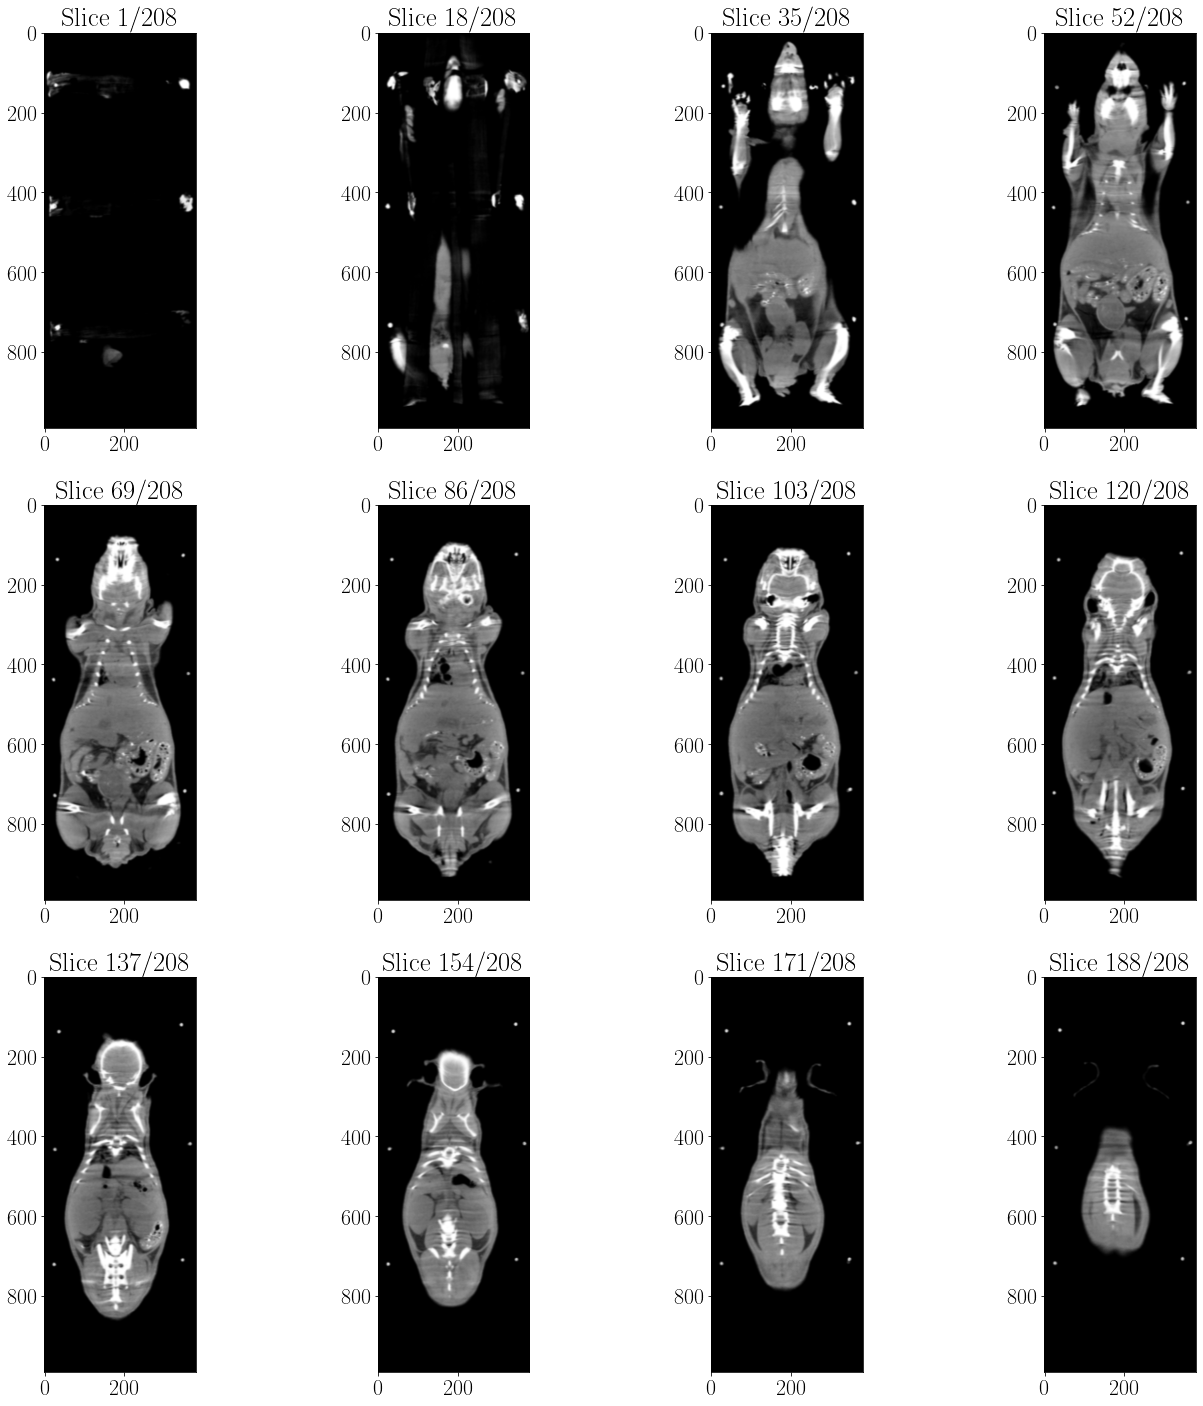

In [12]:
ncols = 4
nrows = 3

step = int(reference_CT_array.shape[0] / (ncols * nrows))
slices = range(0, int(reference_CT_array.shape[0]), step)

fig = plt.figure(figsize= (20,20))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(reference_CT_array.shape[0]))
        ax.imshow(reference_CT_array[slice_id], cmap='gray')
        
plt.tight_layout()

## Create the STL files

Load the phantom

In [13]:
phantom = sitk.ReadImage("digimouse/atlas/atlas_380x992x208.hdr")
phantom_array = sitk.GetArrayFromImage(phantom)

NiftiImageIO (0x55593457ff90): digimouse/atlas/atlas_380x992x208.hdr is Analyze file and it's deprecated 

NiftiImageIO (0x55593457ff90): digimouse/atlas/atlas_380x992x208.hdr is Analyze file and it's deprecated 



Load the labels

In [14]:
df = pd.read_csv("digimouse/atlas/atlas_380x992x208.txt",
                 delimiter=" --> ",
                 names=["Label", "Organs"])

/home/fpvidal/miniconda3/envs/gvxr-validation/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Process every structure of the phantom

In [15]:
if not os.path.exists("digimouse/segmentations"):
    os.mkdir("digimouse/segmentations")

if not os.path.exists("digimouse/meshes"):
    os.mkdir("digimouse/meshes")

meshes = []
phantom_mu = None

for threshold, organ in zip(df["Label"], df["Organs"]):

    if organ == "air":
        mu_511_keV = 0.000104
    elif organ == "background":
        mu_511_keV = 0.0913
    elif organ == "skeleton":
        mu_511_keV = 0.1717
    elif organ == "eye":
        mu_511_keV = 0.1012
    elif organ == "testes"or organ == "testis":
        mu_511_keV = 0.0993
    elif organ == "masseter muscles":
        mu_511_keV = 0.0999
    elif organ == "lungs":
        mu_511_keV = 0.0999
    elif organ == "bladder":
        mu_511_keV = 0.096 
    elif organ == "tumors":
        mu_511_keV = 0.1008
    elif organ == "cerebellum" or organ == "external cerebrum" or organ == "striatum" or organ == "rest of the brain" or organ == "whole brain":
        mu_511_keV = 0.0994
    elif organ == "medulla" or  organ == "olfactory bulbs" or  organ == "heart" or  organ == "lachrymal glands" or  organ == "bladder wall" or  organ == "stomach" or  organ == "spleen" or  organ == "pancreas" or  organ == "liver" or  organ == "kidneys" or  organ == "adrenal glands" or  organ == "skin":
        mu_511_keV = 0.1008
    else:
        raise IOError("Unknown organ: " + organ)

    # Ignore air
    if organ != "whole brain": # and organ != "background":
        organ = organ.replace(" ", "_")
        # print("Process", organ, threshold)
        
        seg_fname = "digimouse/segmentations/" + organ + ".mha"
        mesh_fname = "digimouse/meshes/" + organ + ".stl"
        meshes.append(mesh_fname)

        # Only create the mesh if it does not exist
        if True: #not os.path.exists(mesh_fname):
            
            print("        {")
            print("            \"Label\": \"" + organ + "\",")
            print("            \"Path\": \"" + mesh_fname + "\",")
            print("            \"Unit\": \"mm\",")

            # Only segment the image it is not done as yet
            if not os.path.exists(seg_fname):
            
                # Threshold the phantom
                binary_image = (phantom == threshold)
                sitk.WriteImage(binary_image, seg_fname)

                # # Smooth the binary segmentation
                # smoothed_binary_image = sitk.AntiAliasBinary(binary_image)
                # sitk.WriteImage(smoothed_binary_image, seg_fname)
            else:
                binary_image = sitk.ReadImage(seg_fname)
                # smoothed_binary_image = sitk.ReadImage(seg_fname)
                               
            binary_array = sitk.GetArrayFromImage(binary_image)
            test = binary_array > 0.5
            
#             # binary_array = sitk.GetArrayFromImage(smoothed_binary_image)
            
            average_HU = reference_CT_array[test].mean()

            if phantom_mu is None:
                phantom_mu = np.zeros(phantom_array.shape)

            phantom_mu[test] = mu_511_keV
            
            # print("            \"Material\": [\"mu\",", mu_511_keV, "],")
            print("            \"Material\": [\"HU\",", average_HU, "],")
            print("            \"Type\": \"inner\",")
            print("            \"Opacity\": 0.4")
            print("        },")
            print()

            # Create a VTK image
            vtkimg = sitk2vtk(binary_image, centre=True)
            # vtkimg = sitk2vtk(smoothed_binary_image, centre=True)

            binary_array = sitk.GetArrayFromImage(binary_image)
            min_val = binary_array.min()
            max_val = binary_array.max()
            threshold = min_val + 0.5 * (max_val - min_val)
            
            vtkmesh = extractSurface(vtkimg, threshold)
            
            writeSTL(vtkmesh, mesh_fname)

        {
            "Label": "background",
            "Path": "digimouse/meshes/background.stl",
            "Unit": "mm",
            "Material": ["HU", 4.077802384286048 ],
            "Type": "inner",
            "Opacity": 0.4
        },

        {
            "Label": "skin",
            "Path": "digimouse/meshes/skin.stl",
            "Unit": "mm",
            "Material": ["HU", 117.82013309732957 ],
            "Type": "inner",
            "Opacity": 0.4
        },

        {
            "Label": "skeleton",
            "Path": "digimouse/meshes/skeleton.stl",
            "Unit": "mm",
            "Material": ["HU", 223.1297653115761 ],
            "Type": "inner",
            "Opacity": 0.4
        },

        {
            "Label": "eye",
            "Path": "digimouse/meshes/eye.stl",
            "Unit": "mm",
            "Material": ["HU", 130.32370766488413 ],
            "Type": "inner",
            "Opacity": 0.4
        },

        {
            "Label": "medulla",
  

In [16]:
if phantom_mu is not None:
    temp = sitk.GetImageFromArray(phantom_mu)
    temp.SetSpacing([pixel_width, pixel_width, pixel_height])
    sitk.WriteImage(temp, "gVirtualXRay_output_data/phantom_mu-digimouse.mha", useCompression=True) 
else:
    temp = sitk.ReadImage("gVirtualXRay_output_data/phantom_mu-digimouse.mha")
    phantom_mu = sitk.GetArrayFromImage(temp)

Load the samples. `verbose=2` is used to print the material database for Gate. To disable it, use `verbose=0` or `verbose=1`.

In [17]:
json2gvxr.initSamples(verbose=0)

file_name:	digimouse/meshes/background.stl	nb_faces:	1665500	nb_vertices:	4996500	bounding_box (in cm):	(-1.72, -4.55, -0.95)	(1.56, 4.33, 1.02)
file_name:	digimouse/meshes/skin.stl	nb_faces:	3865300	nb_vertices:	11595900	bounding_box (in cm):	(-1.72, -4.55, -0.95)	(1.56, 4.33, 1.02)
file_name:	digimouse/meshes/skeleton.stl	nb_faces:	1417512	nb_vertices:	4252536	bounding_box (in cm):	(-1.68, -4.21, -0.88)	(1.5, 4.32, 0.99)
file_name:	digimouse/meshes/eye.stl	nb_faces:	5548	nb_vertices:	16644	bounding_box (in cm):	(-0.44, -3.54, -0.14)	(0.49, -3.31, 0.12)
file_name:	digimouse/meshes/medulla.stl	nb_faces:	24196	nb_vertices:	72588	bounding_box (in cm):	(-0.29, -2.66, -0.02)	(0.31, -1.91, 0.3)
file_name:	digimouse/meshes/cerebellum.stl	nb_faces:	19532	nb_vertices:	58596	bounding_box (in cm):	(-0.39, -2.62, 0.25)	(0.39, -2.25, 0.54)
file_name:	digimouse/meshes/olfactory_bulbs.stl	nb_faces:	11892	nb_vertices:	35676	bounding_box (in cm):	(-0.14, -3.64, -0.09)	(0.21, -3.26, 0.19)
file_name:	di

In [18]:
plot = k3d.plot()
plot.background_color = 0xffffff

for sample in json2gvxr.params["Samples"]:
    
    label = sample["Label"]
    fname = sample["Path"]
    
    r, g, b, a = gvxr.getAmbientColour(label)
    R = math.floor(255*r)
    G = math.floor(255*g)
    B = math.floor(255*b)
    A = math.floor(255*a)

    k3d_color = 0;
    k3d_color |= (R & 255) << 16;
    k3d_color |= (G & 255) << 8;
    k3d_color |= (B & 255);

    mesh_from_stl_file = mesh.Mesh.from_file(fname)

    geometry = k3d.mesh(mesh_from_stl_file.vectors.flatten(),
                          range(int(mesh_from_stl_file.vectors.flatten().shape[0] / 3)),
                          color=k3d_color, 
                          wireframe=False, 
                          flat_shading=False,
                          name=fname,
                          opacity = sample["Opacity"])
    
    plot += geometry   
    
plot.display()

Output()

In [19]:
# Grab a screenshot
plot.fetch_screenshot()

# Save the PNG data into a file
# data = base64.b64decode(plot.screenshot)
# with open('plots/digimouse_model.png','wb') as fp:
#     fp.write(data)

## Spectrum

The spectrum is monochromatic.

In [20]:
spectrum, unit, k, f = json2gvxr.initSpectrum(verbose=0)

INIT RENDER


In [21]:
energy_set = sorted(spectrum.keys())

count_set = []

for energy in energy_set:
    count_set.append(spectrum[energy])
    
    print(count_set[-1], "photons of", energy, "keV")

1.0 photons of 511 keV


## Simulation of path lenght on GPU, integration of energy on CPU

## Runing the simulation

Update the 3D visualisation and take a screenshot

In [22]:
gvxr.displayScene()

gvxr.computeXRayImage()

gvxr.useLighing()
gvxr.useWireframe()
gvxr.setZoom(239.6787109375)
gvxr.setSceneRotationMatrix([-0.19267332553863525, -0.06089369207620621, 0.9793692827224731,  0.0,
                              0.9809651970863342,  -0.03645244985818863, 0.19072122871875763, 0.0,
                              0.02408679760992527,  0.9974713325500488,  0.06675821542739868, 0.0, 
                              0.0,                  0.0,                 0.0,                 1.0])

gvxr.displayScene()

0 0 500 500
0 0 800 450


In [23]:
gvxr.renderLoop()

# print(gvxr.getZoom())
# print(gvxr.getSceneRotationMatrix())

In [24]:
screenshot = gvxr.takeScreenshot()

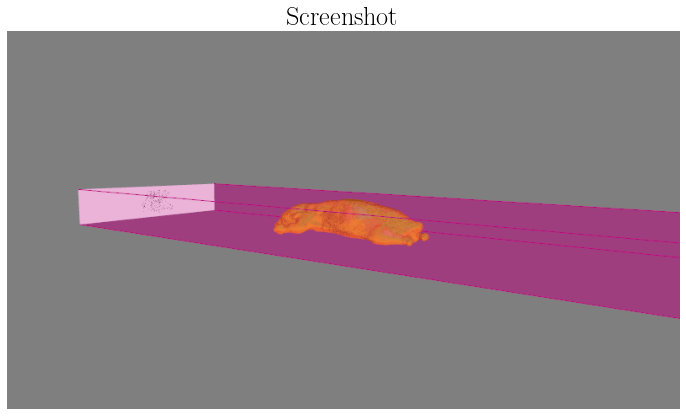

In [25]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-off-digimouse.pdf')
plt.savefig('plots/screenshot-beam-off-digimouse.png')

 Update set of projections while rotating the scene to mimick CT acquisition

In [26]:
%%capture

if True: #not os.path.exists("gVirtualXRay_output_data/flat-digimouse.mha"):


    raw_projections = [];

    # Create a GIF file
    writer = None
    fname_gif = "plots/acquisition-digimouse.gif"

    # if not os.path.exists(fname_gif):
    writer = imageio.get_writer(fname_gif, mode='I')

    # Save the transformation matrix
    transformation_matrix_backup = gvxr.getSceneTransformationMatrix()
    
    for angle_id in range(0, number_of_projections):

        # Compute an X-ray image    
        xray_image = np.array(gvxr.computeXRayImage());

        # Add to the set of projections
        raw_projections.append(xray_image)

        # Update the rendering
        gvxr.displayScene();

        # Take a screenshot
        if writer is not None:
            if not angle_id % 30:
                screenshot = gvxr.takeScreenshot()

                plt.figure(figsize= (10,10))
                plt.title("Projection " + str(angle_id + 1) + "/" + str(number_of_projections))
                plt.imshow(screenshot)
                plt.axis('off')

                plt.tight_layout()

                plt.savefig('temp.png')            
                plt.close()


                image = imageio.imread("temp.png")
                writer.append_data(image)

        # Rotate the sample
        gvxr.rotateScene(-angular_step, 0, 0, 1);

    # Restore the transformation matrix
    gvxr.setSceneTransformationMatrix(transformation_matrix_backup)

    # Update the rendering
    gvxr.displayScene();

    # We're done with the writer
    if writer is not None:
        writer.close()
        # os.remove(temp.tif)

    # Convert to numpy arrays
    raw_projections = np.array(raw_projections)

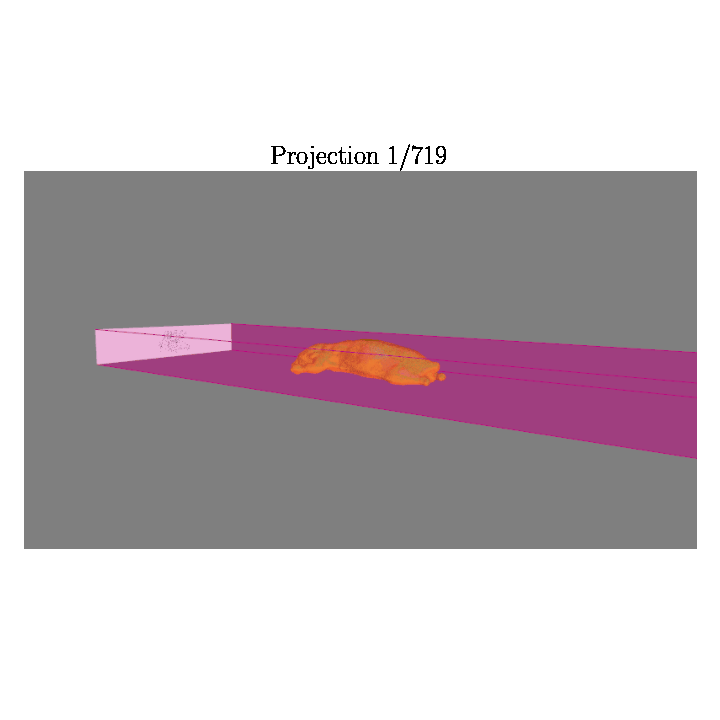

In [27]:
with open('plots/acquisition-digimouse.gif','rb') as f:
    display(Image(data=f.read(), format='png', width=800))

# Perform flat-field correction

In [28]:
if True: #not os.path.exists("gVirtualXRay_output_data/flat-digimouse.mha"):

    # Create a mock dark field image
    dark_field_image = np.zeros(raw_projections.shape);

    # Create a mock flat field image
    flat_field_image = np.ones(raw_projections.shape);

    # Retrieve the total energy
    total_energy = 0.0;
    energy_bins = gvxr.getEnergyBins("MeV");
    photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

    for energy, count in zip(energy_bins, photon_count_per_bin):
        total_energy += energy * count;
    flat_field_image *= total_energy;

    # Apply the actual flat-field correction on the raw projections
    corrected_projections = (raw_projections - dark_field_image) / (flat_field_image - dark_field_image)
    # corrected_projections = tomopy.normalize(raw_projections, flat_field_image, dark_field_image)

    raw_projections = None # Not needed anymore

## Save the projections using SimpleITK

In [29]:
if True: #not os.path.exists("gVirtualXRay_output_data/flat-digimouse.mha"):

    corrected_projections = np.array(corrected_projections).astype(np.single)

    sitk_image = sitk.GetImageFromArray(corrected_projections)
    sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
    sitk.WriteImage(sitk_image, "gVirtualXRay_output_data/flat-digimouse.mha", useCompression=True) 
else:
    temp = sitk.ReadImage("gVirtualXRay_output_data/flat-digimouse.mha")
    corrected_projections = sitk.GetArrayFromImage(temp)

## Calculate $-\log(\mathbf{corrected\_projections}) $ to linearize transmission tomography data

In [30]:
if not os.path.exists("gVirtualXRay_output_data/sinograms-digimouse.mha"):
    # Create a temporary image to hold the sinogram
    minus_log_projs = copy.deepcopy(corrected_projections);

    # Make sure no value is negative or null (because of the log function)
    # It should not be the case, however, when the Laplacian is used to simulate
    # phase contrast, negative values can be generated.
    threshold = 0.000000001
    minus_log_projs[minus_log_projs < threshold] = threshold;

    # Apply the minus log normalisation
    minus_log_projs = -np.log(minus_log_projs);

    # Rescale the data taking into account the pixel size
    pixel_spacing_in_mm = gvxr.getDetectorSize("mm")[0] / gvxr.getDetectorNumberOfPixels()[0]
    minus_log_projs /= pixel_spacing_in_mm * (gvxr.getUnitOfLength("mm") / gvxr.getUnitOfLength("cm"));

    # Make sure the data is in single-precision floating-point numbers
    minus_log_projs = np.array(minus_log_projs).astype(np.single)

else:
    temp = sitk.ReadImage("gVirtualXRay_output_data/sinograms-digimouse.mha")
    minus_log_projs = sitk.GetArrayFromImage(temp)
    
# Reformat the projections into a set of sinograms
sinograms = np.swapaxes(minus_log_projs, 0, 1)
sinograms = np.array(sinograms).astype(np.single)

corrected_projections = None # Not needed anymore

Save the volume using SimpleITK

In [31]:
if not os.path.exists("gVirtualXRay_output_data/sinograms-digimouse.mha"):
    sitk_image = sitk.GetImageFromArray(minus_log_projs)
    sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
    sitk.WriteImage(sitk_image, "gVirtualXRay_output_data/sinograms-digimouse.mha", useCompression=True)

Plot some sinograms

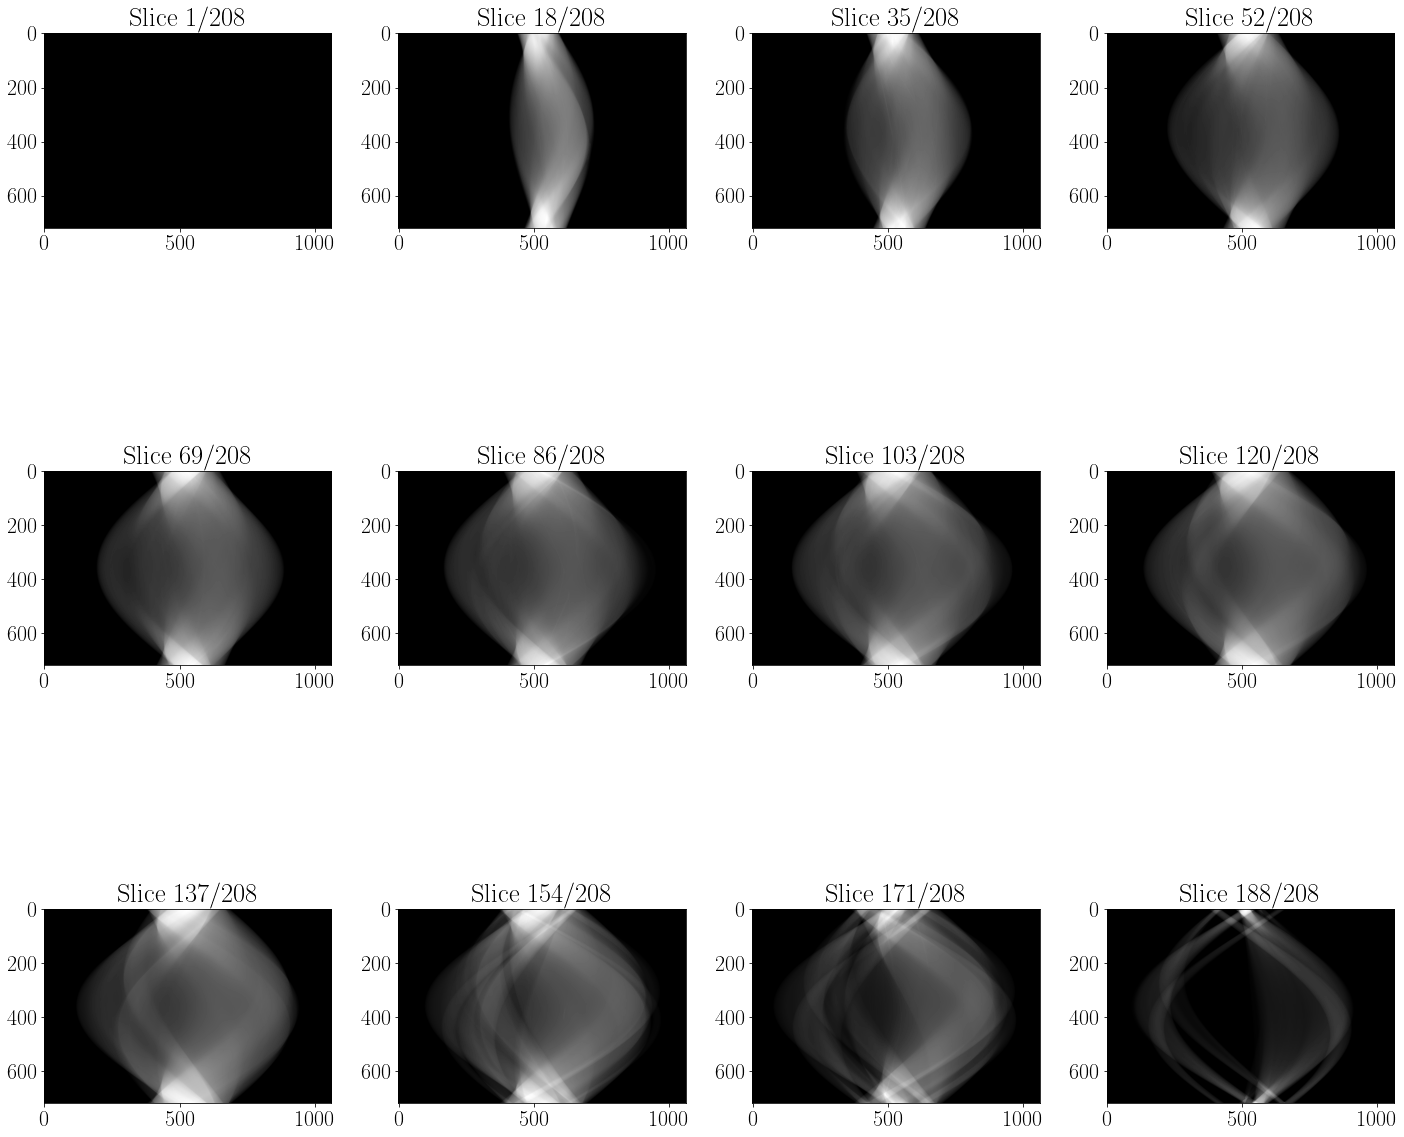

In [32]:
ncols = 4
nrows = 3

step = int(sinograms.shape[0] / (ncols * nrows))
slices = range(0, int(sinograms.shape[0]), step)

fig = plt.figure(figsize= (20,20))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(sinograms.shape[0]))
        ax.imshow(sinograms[slice_id], cmap='gray')
        
plt.tight_layout()

Find the rotation axis using Tomopy

In [33]:
# rot_center = tomopy.find_center(sinograms, theta, init=290, ind=0, tol=0.5)

Reconstruct the CT slice using Tomopy

In [34]:
# if True: #not os.path.exists("gVirtualXRay_output_data/volume_in_mu-digimouse.mha"):
#     theta_rad = np.array(theta_deg) * math.pi / 180
#     rot_centre = minus_log_projs.shape[2] / 2
#     # rot_centre = tomopy.find_center(minus_log_projs, theta_rad, init=rot_centre, ind=0, tol=0.01)
#     print("Projection sizes:", minus_log_projs.shape)
#     print("Rotation centre:", rot_centre)
#     CT_volume_in_mu = tomopy.recon(minus_log_projs,
#                              theta_rad,
#                              center=rot_centre,
#                              algorithm='fbp',
#                              sinogram_order=False)

# # sinogram = None # Not needed anymore

Reconstruct the CT slice using Scikit-Image

In [35]:
if True: #not os.path.exists("gVirtualXRay_output_data/volume_in_mu-digimouse.mha"):
    CT_volume_in_mu = []

    for sinogram in sinograms:
        CT_volume_in_mu.append(iradon(sinogram.T, theta=theta_deg, circle=True))

sinogram = None # Not needed anymore

Save the volume using SimpleITK

In [36]:
if True: #not os.path.exists("gVirtualXRay_output_data/volume_in_mu-digimouse.mha"):
    
    CT_volume_in_mu = np.array(CT_volume_in_mu).astype(np.single)

    # Crop the volume if need
    if CT_volume_in_mu.shape != phantom_array.shape:
        print("Crop")
        half_width_delta = round((CT_volume_in_mu.shape[2] - phantom_array.shape[2]) / 2)
        half_height_delta = round((CT_volume_in_mu.shape[1] - phantom_array.shape[1]) / 2)
        
        CT_volume_in_mu = CT_volume_in_mu[:,
                                          half_height_delta:phantom_array.shape[1] + half_height_delta,
                                          half_width_delta:phantom_array.shape[2] + half_width_delta]
    
    temp = sitk.GetImageFromArray(CT_volume_in_mu)
    temp.SetSpacing([pixel_width, pixel_width, pixel_height])

    sitk.WriteImage(temp, "gVirtualXRay_output_data/volume_in_mu-digimouse.mha", useCompression=True)
else:
    temp = sitk.ReadImage("gVirtualXRay_output_data/volume_in_mu-digimouse.mha")
    CT_volume_in_mu = sitk.GetArrayFromImage(temp)

Crop


In [37]:
if True: #not os.path.exists("gVirtualXRay_output_data/volume_in_HU-digimouse.mha"):
    
    mu_air = 0.0
    mu_water = gvxr.getMassAttenuationFromCompound("H2O",
        json2gvxr.params["Source"]["Beam"][0]["Energy"],
        json2gvxr.params["Source"]["Beam"][0]["Unit"])
    
    CT_volume_in_HU = 1000 * (CT_volume_in_mu - mu_water) / (mu_water - mu_air)

    sitk_image = sitk.GetImageFromArray(CT_volume_in_HU)
    sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])

    sitk.WriteImage(sitk_image, "gVirtualXRay_output_data/volume_in_HU-digimouse.mha", useCompression=True)
else:
    sitk_image = sitk.ReadImage("gVirtualXRay_output_data/volume_in_HU-digimouse.mha")
    CT_volume_in_HU = sitk.GetArrayFromImage(sitk_image)

## Volume rendering of the CT data

In [38]:
raise IOError("OOPS")

OSError: OOPS

Save an X-ray image

In [ ]:
# Compute the L-buffers on the GPU and integrate on the GPU
x_ray_image_integration_GPU = np.array(gvxr.computeXRayImage())
x_ray_image_integration_GPU = resize(x_ray_image_integration_GPU, gate_image.shape)
imsave('gVirtualXRay_output_data/projection_raw_integration_GPU-digimouse.tif', x_ray_image_integration_GPU.astype(np.single))

Flat-field correction

In [ ]:
total_energy_in_keV = 0.0
for energy, count in zip(energy_set, count_set):
    total_energy_in_keV += energy * count
    
total_energy_in_MeV = gvxr.getTotalEnergyWithDetectorResponse()

In [ ]:
white = np.ones(x_ray_image_integration_GPU.shape) * total_energy_in_MeV
dark = np.zeros(x_ray_image_integration_GPU.shape)

x_ray_image_integration_GPU = (x_ray_image_integration_GPU - dark) / (white - dark)

Save the corresponding image

In [ ]:
imsave('gVirtualXRay_output_data/projection_corrected_integration_GPU_digimouse.tif', x_ray_image_integration_GPU.astype(np.single))

In [ ]:
plt.figure(figsize= (20,10))

plt.suptitle("Image simulated using gVirtualXRay,\nintegration on GPU", y=1.02)

plt.subplot(121)
plt.imshow(x_ray_image_integration_GPU, cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a linear colour scale")

plt.subplot(122)
plt.imshow(x_ray_image_integration_GPU, norm=PowerNorm(gamma=1./0.75), cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a Power-law colour scale")

plt.tight_layout()

plt.savefig('plots/x_ray_image_integration_GPU-digimouse.pdf')
plt.savefig('plots/x_ray_image_integration_GPU-digimouse.png')

Compare the manual implementation with gvxr's

In [ ]:
compareImages(x_ray_image_integration_GPU, gate_image,
              "gVirtualXRay with integration on GPU vs Gate\n(checkerboard comparison)",
              'plots/comparison_integration_GPU-digimouse')

## Comparison the analytic simulation with the Monte Carlo simulation

### Quantitative validation

Compute image metrics between the two simulated images:

1. [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD),
2. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)), and
3. [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity). 


We use these three metrics as one is a disimilarity measurement (MAPE), two are similarity measurement (ZNCC & SSIM). MAPE and ZNCC can be expressed as a percentage, which eases the interpretation of the numerical values. SSIM is a number between 0 and 1. A good value of MAPE s 0%; of ZNCC 100%, and SSIM 1.

In [ ]:
MAPE_integration_GPU = mape(gate_image, x_ray_image_integration_GPU)
ZNCC_integration_GPU = np.mean((gate_image - gate_image.mean()) / gate_image.std() * (x_ray_image_integration_GPU - x_ray_image_integration_GPU.mean()) / x_ray_image_integration_GPU.std())
SSIM_integration_GPU = ssim(gate_image, x_ray_image_integration_GPU, data_range=gate_image.max() - gate_image.min())

print("MAPE_integration_GPU:", "{0:0.2f}".format(100 * MAPE_integration_GPU) + "%")
print("ZNCC_integration_GPU:", "{0:0.2f}".format(100 * ZNCC_integration_GPU) + "%")
print("SSIM_integration_GPU:", "{0:0.2f}".format(SSIM_integration_GPU))

Get the total number of triangles

In [ ]:
number_of_triangles = 0

for mesh in json2gvxr.params["Samples"]:
    label = mesh["Label"]
    number_of_triangles += gvxr.getNumberOfPrimitives(label)

In [ ]:
runtime_avg = round(np.mean(runtimes))
runtime_std = round(np.std(runtimes))

Print a row of the table for the paper

In [ ]:
print("Polychromatic, detector energy response, paediatric & Gate & " + 
      "{0:0.2f}".format(100 * MAPE_integration_GPU) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC_integration_GPU) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_integration_GPU) + "    &    $" +
      str(json2gvxr.params["Detector"]["NumberOfPixels"][0]) + " \\pm " + str(json2gvxr.params["Detector"]["NumberOfPixels"][1]) + "$    &    " +
      str(number_of_triangles) + "    &    " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

In both cases, MAPE is very small (less than 1%), ZNCC is very high (more than 99%), and SSIM is very high (almost 1). We can conclude that the two images are similar. The main difference lie in the Poisson noise affecting the Monte Carlo simulation.

### Qualitative validation

Checkboard comparison

In [ ]:
font = {'size'   : 15
       }
matplotlib.rc('font', **font)

In [ ]:
fullCompareImages(gate_image,
                  x_ray_image_integration_GPU,
                  "gVirtualXRay\n with integration on GPU",
                  "plots/full_comparison_integration_GPU-digimouse", log=True)

Plot the profiles

In [ ]:
font = {'size'   : 22
       }
matplotlib.rc('font', **font)

In [ ]:
plotTwoProfiles(json2gvxr, gate_image, x_ray_image_integration_GPU, "plots/profiles-checkerboard-digimouse")

In [ ]:
spacing = json2gvxr.params["Detector"]["Size"][0] / json2gvxr.params["Detector"]["NumberOfPixels"][0]
min_limit = round(40)
max_limit = round(512 * spacing - 40)
plotTwoProfiles(json2gvxr, gate_image, x_ray_image_integration_GPU, "plots/profiles-zoom-checkerboard-digimouse", [min_limit, max_limit])

## All done

Destroy the window

In [ ]:
gvxr.destroyAllWindows()